## EIA Monthly Electric Grid Data - CO2 Emissions Intensity Model

Goal:  predict how adding X megawatts of solar or wind generation capacity within a Balancing Authority (BA) will affect CO2 emissions per megawatt-hour generated

Monthly generation capacity and operations data was retrieved from the U.S. Energy Information Administration API

See gencap_EDA_prep and genops_EDA_prep for data cleaning and transformation

In [115]:
import pandas as pd
import numpy as np

# load balancing authority generation configuration and operation (output) files to data frames
explan_path = 'genconf.csv'
resp_path = 'genout.csv'
genconf = pd.read_csv(explan_path, low_memory=False)
genout = pd.read_csv(resp_path, low_memory=False)

"genconf" holds monthly generation configuration data for each BA. Columns named with EIA energy source codes contain total installed generation capacity for that energy source. "av_lat" and "av_lon" contain the mean location of power plants in the BA.

In [116]:
genconf.head()

,ba_code,period,BIT,DFO,GEO,JF,KER,LIG,MSW,NG,...,SGP,SUB,SUN,TDF,WAT,WC,WND,WO,av_lat,av_lon
0,AEC,2013-01-01,538.0,0.0,0.0,0.0,0.0,0.0,0.0,1330.0,...,0.0,0.0,0.0,0.0,8.2,0.0,0.0,0.0,31.264018,-86.673644
1,AEC,2013-02-01,538.0,0.0,0.0,0.0,0.0,0.0,0.0,1330.0,...,0.0,0.0,0.0,0.0,8.2,0.0,0.0,0.0,31.264018,-86.673644
2,AEC,2013-03-01,538.0,0.0,0.0,0.0,0.0,0.0,0.0,1330.0,...,0.0,0.0,0.0,0.0,8.2,0.0,0.0,0.0,31.264018,-86.673644
3,AEC,2013-04-01,538.0,0.0,0.0,0.0,0.0,0.0,0.0,1330.0,...,0.0,0.0,0.0,0.0,8.2,0.0,0.0,0.0,31.264018,-86.673644
4,AEC,2013-05-01,538.0,0.0,0.0,0.0,0.0,0.0,0.0,1330.0,...,0.0,0.0,0.0,0.0,8.2,0.0,0.0,0.0,31.264018,-86.673644


In [117]:
# EIA data is not finalized until fall of the year following the reporting period, so cut off data at end of 2021
data_cutoff = '2022-01-01'
genconf = genconf[genconf.period < data_cutoff]

Normalize installed capacity for each energy source as a proportion of total capacity

In [118]:
# calculate total generation capacity per row
genconf['total_cap_mw'] = genconf.drop(['av_lat','av_lon'], axis=1).sum(axis=1, numeric_only=True)

In [119]:
genconf.head().T

,0,1,2,3,4
ba_code,AEC,AEC,AEC,AEC,AEC
period,2013-01-01,2013-02-01,2013-03-01,2013-04-01,2013-05-01
BIT,538.0,538.0,538.0,538.0,538.0
DFO,0.0,0.0,0.0,0.0,0.0
GEO,0.0,0.0,0.0,0.0,0.0
JF,0.0,0.0,0.0,0.0,0.0
KER,0.0,0.0,0.0,0.0,0.0
LIG,0.0,0.0,0.0,0.0,0.0
MSW,0.0,0.0,0.0,0.0,0.0
NG,1330.0,1330.0,1330.0,1330.0,1330.0


"genout" contains monthly data for each BA:  net electricity generated (megawatt-hours), CO2 emitted (metric kilotons), and Carbon Intensity aka specific CO2 emission (kilograms per megawatt-hour)

In [120]:
genout.head()

,Unnamed: 0,period,ba_code,gen_mwh,co2_kton,kg_co2_per_mwh
0,0,2008-01-01,AEC,956757.90,798.625086,834.720138
1,1,2008-01-01,AECI,3538481.16,2810.807112,794.354127
2,2,2008-01-01,AVA,1171593.70,139.373992,118.961029
3,3,2008-01-01,AZPS,4535011.56,4078.848443,899.413020
4,4,2008-01-01,BANC,1456123.84,557.080674,382.577813


In [121]:
genout = genout[['ba_code', 'period', 'gen_mwh', 'co2_kton', 'kg_co2_per_mwh']]

In [122]:
genout.head()

,ba_code,period,gen_mwh,co2_kton,kg_co2_per_mwh
0,AEC,2008-01-01,956757.90,798.625086,834.720138
1,AECI,2008-01-01,3538481.16,2810.807112,794.354127
2,AVA,2008-01-01,1171593.70,139.373992,118.961029
3,AZPS,2008-01-01,4535011.56,4078.848443,899.413020
4,BANC,2008-01-01,1456123.84,557.080674,382.577813


Normalize electricity generated as a proportion of total capacity. Intent is to use this as a feature representing how much of its capacity a BA used on average.

In [123]:
#genout.groupby('period')['total_cap_mw'].sum().plot(x='period',y='total_cap_mw', rot=90)

Based on above, suspect missing data in 2022. EIA website states that data is not finalized until the fall following the reporting year.

In [124]:
# remove rows with nonsense generation values (generation exceeds reported capacity)
#genout_norm = genout_norm[genout_norm.avg_mw_per_cap <= 1]

In [125]:
genout = genout.dropna()
genconf = genconf.dropna()

Join generation configuration and generation output data frames 

In [126]:
gen = genconf.set_index(['ba_code', 'period']).join(genout.set_index(['ba_code', 'period']))

In [127]:
gen.shape

(6996, 29)

In [128]:
gen.head()

BIT  DFO  GEO   JF  KER  LIG  MSW      NG  NUC  OTH   
ba_code period                                                              
AEC     2013-01-01  538.0  0.0  0.0  0.0  0.0  0.0  0.0  1330.0  0.0  4.8  \
        2013-02-01  538.0  0.0  0.0  0.0  0.0  0.0  0.0  1330.0  0.0  4.8   
        2013-03-01  538.0  0.0  0.0  0.0  0.0  0.0  0.0  1330.0  0.0  4.8   
        2013-04-01  538.0  0.0  0.0  0.0  0.0  0.0  0.0  1330.0  0.0  4.8   
        2013-05-01  538.0  0.0  0.0  0.0  0.0  0.0  0.0  1330.0  0.0  4.8   

                    ...  WAT   WC  WND   WO     av_lat     av_lon   
ba_code period      ...                                             
AEC     2013-01-01  ...  8.2  0.0  0.0  0.0  31.264018 -86.673644  \
        2013-02-01  ...  8.2  0.0  0.0  0.0  31.264018 -86.673644   
        2013-03-01  ...  8.2  0.0  0.0  0.0  31.264018 -86.673644   
        2013-04-01  ...  8.2  0.0  0.0  0.0  31.264018 -86.673644   
        2013-05-01  ...  8.2  0.0  0.0  0.0  31.264018 -86.673644   

                    total_cap_mw    gen_mwh    co2_kton  kg_co2_per_mwh  
ba_code period                                                           
AEC     2013-01-01        1881.0  860972.86  453.815890      527.096626  
        2013-02-01        1881.0  827951.96  451.042088      544.768428  
        2013-03-01        1881.0  881830.44  473.692029      537.169060  
        2013-04-01        1881.0  660056.56  497.865125      754.276459  
        2013-05-01        1881.0  580954.20  558.151669      960.749865  

[5 rows x 29 columns]

In [129]:
gen = gen.reset_index()

In [130]:
ng_price_path = 'NG_price.csv'
ng_price = pd.read_csv(ng_price_path, low_memory=False)
ng_price.head()

,period,NG_price
0,1997-01-01,3.45
1,1997-02-01,2.15
2,1997-03-01,1.89
3,1997-04-01,2.03
4,1997-05-01,2.25


In [131]:
gen = gen.set_index(['period']).join(ng_price.set_index('period')).reset_index()

In [132]:
gen.shape

(6996, 32)

In [133]:
gen.head()

,period,ba_code,BIT,DFO,GEO,JF,KER,LIG,MSW,NG,...,WC,WND,WO,av_lat,av_lon,total_cap_mw,gen_mwh,co2_kton,kg_co2_per_mwh,NG_price
0,2013-01-01,AEC,538.0,0.0,0.0,0.0,0.0,0.0,0.0,1330.0,...,0.0,0.0,0.0,31.264018,-86.673644,1881.0,860972.86,453.815890,527.096626,3.33
1,2013-01-01,AECI,0.0,143.5,0.0,0.0,0.0,0.0,0.0,3063.5,...,0.0,312.5,0.0,39.513189,-92.651078,6107.4,3873454.80,3185.278603,822.335297,3.33
2,2013-01-01,AVA,0.0,2.8,0.0,0.0,0.0,0.0,26.0,563.7,...,0.0,105.3,0.0,47.733859,-117.229689,2008.5,1295255.92,131.395915,101.443979,3.33
3,2013-01-01,AZPS,2269.6,123.8,0.0,0.0,0.0,0.0,0.0,3020.5,...,0.0,174.3,0.0,33.445402,-112.515959,6915.3,4218304.56,3977.130799,942.826850,3.33
4,2013-01-01,BANC,0.0,143.4,0.0,0.0,0.0,0.0,0.0,1769.8,...,0.0,0.0,0.0,38.609879,-121.310059,2762.0,1494348.18,521.837142,349.207199,3.33


In [134]:
gen = gen.dropna()

In [135]:
gen.shape

(5563, 32)

In [136]:
gen = gen.reset_index()
gen.head()

,index,period,ba_code,BIT,DFO,GEO,JF,KER,LIG,MSW,...,WC,WND,WO,av_lat,av_lon,total_cap_mw,gen_mwh,co2_kton,kg_co2_per_mwh,NG_price
0,0,2013-01-01,AEC,538.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,31.264018,-86.673644,1881.0,860972.86,453.815890,527.096626,3.33
1,1,2013-01-01,AECI,0.0,143.5,0.0,0.0,0.0,0.0,0.0,...,0.0,312.5,0.0,39.513189,-92.651078,6107.4,3873454.80,3185.278603,822.335297,3.33
2,2,2013-01-01,AVA,0.0,2.8,0.0,0.0,0.0,0.0,26.0,...,0.0,105.3,0.0,47.733859,-117.229689,2008.5,1295255.92,131.395915,101.443979,3.33
3,3,2013-01-01,AZPS,2269.6,123.8,0.0,0.0,0.0,0.0,0.0,...,0.0,174.3,0.0,33.445402,-112.515959,6915.3,4218304.56,3977.130799,942.826850,3.33
4,4,2013-01-01,BANC,0.0,143.4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,38.609879,-121.310059,2762.0,1494348.18,521.837142,349.207199,3.33


In [137]:
#move_col = gen_norm.pop('ba_code')
#gen_norm.insert(0, move_col.name, move_col)
#gen_norm.head()

In [138]:
gen.columns

Index(['index', 'period', 'ba_code', 'BIT', 'DFO', 'GEO', 'JF', 'KER', 'LIG',
       'MSW', 'NG', 'NUC', 'OTH', 'PC', 'PG', 'RC', 'RFO', 'SGC', 'SGP', 'SUB',
       'SUN', 'TDF', 'WAT', 'WC', 'WND', 'WO', 'av_lat', 'av_lon',
       'total_cap_mw', 'gen_mwh', 'co2_kton', 'kg_co2_per_mwh', 'NG_price'],
      dtype='object')

In [139]:
#move_col = gen.pop('NG_price')
#gen.insert(gen.columns.get_loc('avg_mw_per_cap'), move_col.name, move_col)
#gen.head()

In [140]:
gen = gen.sort_values(by=['ba_code','period'])

In [141]:
gen = gen[gen.kg_co2_per_mwh >= 0]

<Axes: xlabel='period'>

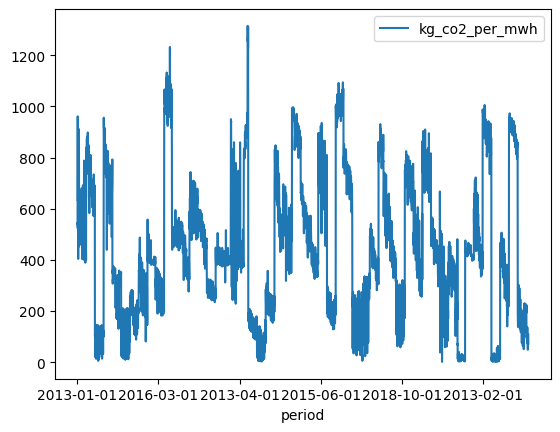

In [142]:
gen.plot(x='period',y='kg_co2_per_mwh')

Use Fast Fourier Transform to check for actual seasonality in the response variable

In [143]:
gen['period'] = pd.to_datetime(gen['period'])
# create Julian date column (days since noon on 1 Jan 4713 BC)
gen['julian'] = gen['period'].apply(lambda x : pd.Timestamp(x).to_julian_date())
# create sine and cosine of time features
gen['sin_year'] = np.sin(gen['julian'] / 365.25 * 2 * np.pi)
gen['cos_year'] = np.cos(gen['julian'] / 365.25 * 2 * np.pi)
gen['sin_6mo'] = np.sin(gen['julian'] / (365.25/2) * 2 * np.pi)
gen['cos_6mo'] = np.cos(gen['julian'] / (365.25/2) * 2 * np.pi)
gen = gen.drop(columns=['julian'])

Examine features graphically

In [144]:
gen.columns

Index(['index', 'period', 'ba_code', 'BIT', 'DFO', 'GEO', 'JF', 'KER', 'LIG',
       'MSW', 'NG', 'NUC', 'OTH', 'PC', 'PG', 'RC', 'RFO', 'SGC', 'SGP', 'SUB',
       'SUN', 'TDF', 'WAT', 'WC', 'WND', 'WO', 'av_lat', 'av_lon',
       'total_cap_mw', 'gen_mwh', 'co2_kton', 'kg_co2_per_mwh', 'NG_price',
       'sin_year', 'cos_year', 'sin_6mo', 'cos_6mo'],
      dtype='object')

In [145]:
test = list(gen.columns.values)
test

['index',
 'period',
 'ba_code',
 'BIT',
 'DFO',
 'GEO',
 'JF',
 'KER',
 'LIG',
 'MSW',
 'NG',
 'NUC',
 'OTH',
 'PC',
 'PG',
 'RC',
 'RFO',
 'SGC',
 'SGP',
 'SUB',
 'SUN',
 'TDF',
 'WAT',
 'WC',
 'WND',
 'WO',
 'av_lat',
 'av_lon',
 'total_cap_mw',
 'gen_mwh',
 'co2_kton',
 'kg_co2_per_mwh',
 'NG_price',
 'sin_year',
 'cos_year',
 'sin_6mo',
 'cos_6mo']

In [146]:
not_features = ['ba_code', 'index', 'period', 'kg_co2_per_mwh', 'gen_mwh', 'co2_kton', 'total_cap_mw',]
X_names = [i for i in list(gen.columns.values) if i not in not_features]
X_names

['BIT',
 'DFO',
 'GEO',
 'JF',
 'KER',
 'LIG',
 'MSW',
 'NG',
 'NUC',
 'OTH',
 'PC',
 'PG',
 'RC',
 'RFO',
 'SGC',
 'SGP',
 'SUB',
 'SUN',
 'TDF',
 'WAT',
 'WC',
 'WND',
 'WO',
 'av_lat',
 'av_lon',
 'NG_price',
 'sin_year',
 'cos_year',
 'sin_6mo',
 'cos_6mo']

In [149]:
import seaborn as sns

for X in X_names:
    plt.figure()
    plt.title(X)
    plt.hist(gen[X], bins=40)


NameError: name 'plt' is not defined

In [ ]:
gen.head()

,ba_code,index,period,av_lat,av_lon,BIT,DFO,GEO,JF,KER,...,gen_mwh,co2_kton,kg_co2_per_mwh,total_cap_mw,NG_price,avg_mw_per_cap,sin_year,cos_year,sin_6mo,cos_6mo
0,AEC,0,2013-01-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,...,860972.86,453.815890,527.096626,1881.0,0.389016,0.615216,-0.217577,0.976043,-0.424728,0.905321
45,AEC,63,2013-02-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,...,827951.96,451.042088,544.768428,1881.0,0.389016,0.591621,0.308812,0.951123,0.587437,0.809270
93,AEC,126,2013-03-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,...,881830.44,473.692029,537.169060,1881.0,0.498856,0.630120,0.714292,0.699848,0.999791,-0.020426
138,AEC,189,2013-04-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,...,660056.56,497.865125,754.276459,1881.0,0.581236,0.471650,0.970882,0.239557,0.465162,-0.885225
188,AEC,252,2013-05-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,...,580954.20,558.151669,960.749865,1881.0,0.551487,0.415126,0.962652,-0.270742,-0.521260,-0.853398


Most features appear right-skewed. Apply log transform using log(1+X). Avoids undefined result at log(0).

In [ ]:
import numpy as np

# list feature names to log transform
no_log = ['av_lat', 'av_lon', 'sin_year', 'cos_year', 'sin_6mo', 'cos_6mo']
X_to_log = [i for i in X_names if i not in no_log]
X_log_names = [f"log_{i}" for i in X_to_log]
gen_norm[X_log_names] = gen_norm[X_to_log].apply(lambda x: np.log(1+x))
gen_norm.head()


,ba_code,index,period,av_lat,av_lon,BIT,DFO,GEO,JF,KER,...,log_SGP,log_SUB,log_SUN,log_TDF,log_WAT,log_WC,log_WND,log_WO,log_NG_price,log_avg_mw_per_cap
0,AEC,0,2013-01-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00435,0.0,0.0,0.0,0.328596,0.479469
45,AEC,63,2013-02-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00435,0.0,0.0,0.0,0.328596,0.464753
93,AEC,126,2013-03-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00435,0.0,0.0,0.0,0.404702,0.488654
138,AEC,189,2013-04-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00435,0.0,0.0,0.0,0.458207,0.386384
188,AEC,252,2013-05-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00435,0.0,0.0,0.0,0.439214,0.347219


In [ ]:
# one hot encode by BA
#gen_norm['ba'] = gen_norm['ba_code']
#gen_norm = pd.get_dummies(gen_norm, columns=['ba'], dtype=np.uint8)

Correlation Matrix

<Axes: >

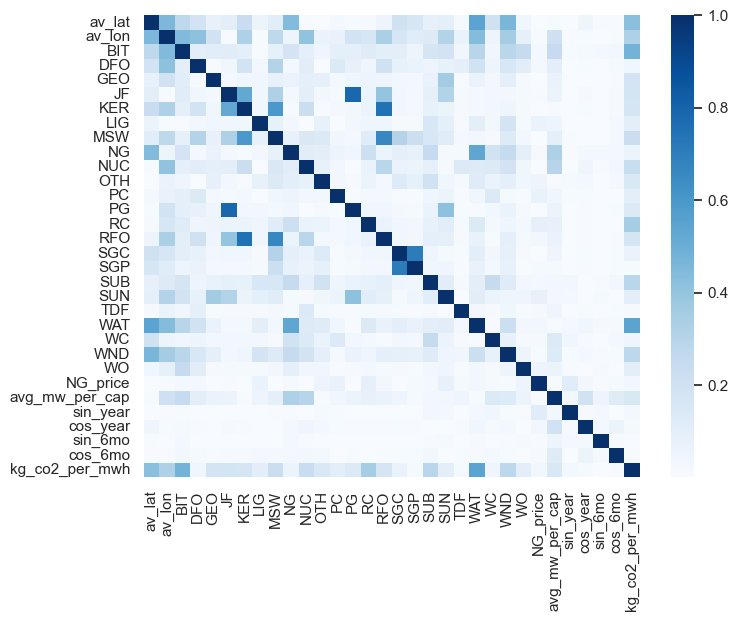

In [ ]:
import seaborn as sns

sns.heatmap(data=abs(gen[X_names + ['kg_co2_per_mwh']].corr(numeric_only=True)), cmap='Blues', xticklabels=True, yticklabels=True)

Select feature names manually

In [ ]:
X_names = [i for i in list(gen.columns.values) if i not in not_features]
X_names

['av_lat',
 'av_lon',
 'BIT',
 'DFO',
 'GEO',
 'JF',
 'KER',
 'LIG',
 'MSW',
 'NG',
 'NUC',
 'OTH',
 'PC',
 'PG',
 'RC',
 'RFO',
 'SGC',
 'SGP',
 'SUB',
 'SUN',
 'TDF',
 'WAT',
 'WC',
 'WND',
 'WO',
 'NG_price',
 'avg_mw_per_cap',
 'sin_year',
 'cos_year',
 'sin_6mo',
 'cos_6mo',
 'log_BIT',
 'log_DFO',
 'log_GEO',
 'log_JF',
 'log_KER',
 'log_LIG',
 'log_MSW',
 'log_NG',
 'log_NUC',
 'log_OTH',
 'log_PC',
 'log_PG',
 'log_RC',
 'log_RFO',
 'log_SGC',
 'log_SGP',
 'log_SUB',
 'log_SUN',
 'log_TDF',
 'log_WAT',
 'log_WC',
 'log_WND',
 'log_WO',
 'log_NG_price',
 'log_avg_mw_per_cap']

<Axes: >

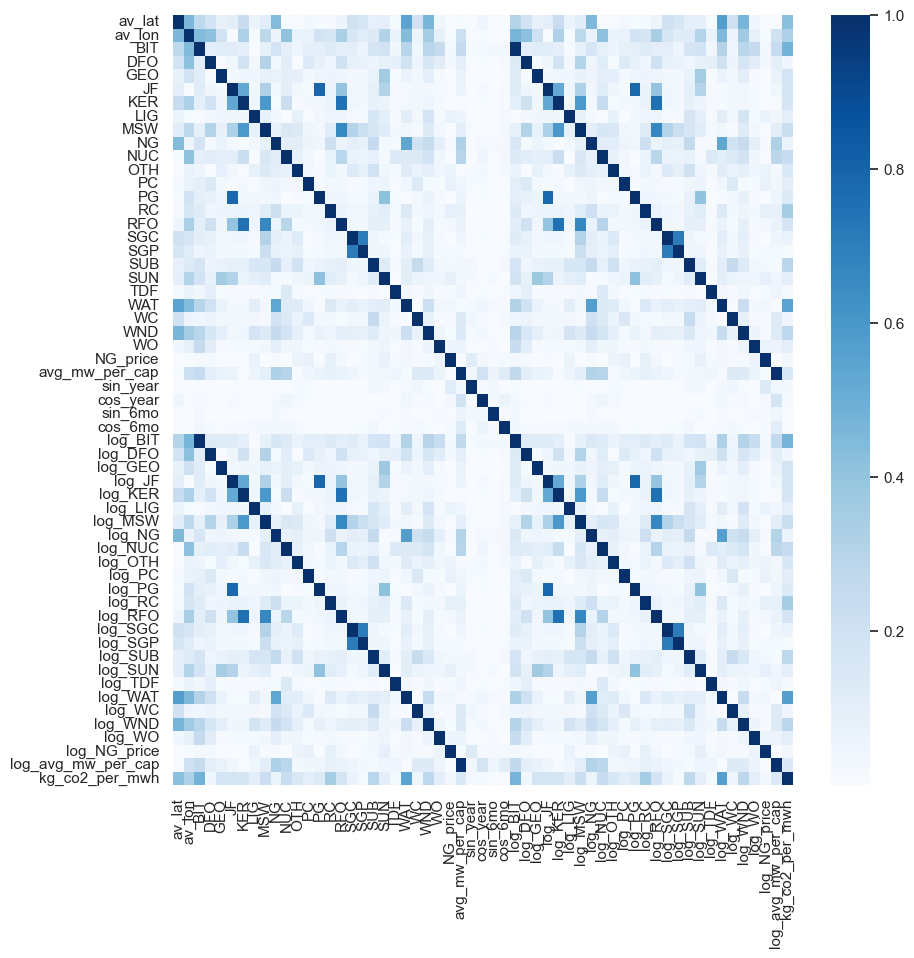

In [ ]:
import seaborn as sns

sns.set(rc={'figure.figsize':(10,10)})
sns.heatmap(data=abs(gen[X_names + ['kg_co2_per_mwh']].corr(numeric_only=True)), cmap='Blues', xticklabels=True, yticklabels=True)

In [ ]:
gen.shape

(4779, 63)

In [ ]:
len(X_names)

56

In [ ]:
def normShiftLogit(y, lower_bound, upper_bound, shift):
    ny = (y - lower_bound) / (upper_bound - lower_bound)
    nsy = ny + shift
    nsly = np.log(nsy / (1 - nsy))
    return nsly
    
def unNormShiftLogit(nsly, lower_bound, upper_bound, shift):
    nsy = np.exp(nsly) / (1 + np.exp(nsly))
    ny = nsy - shift
    y = ny * (upper_bound - lower_bound) + lower_bound
    return y



<Axes: >

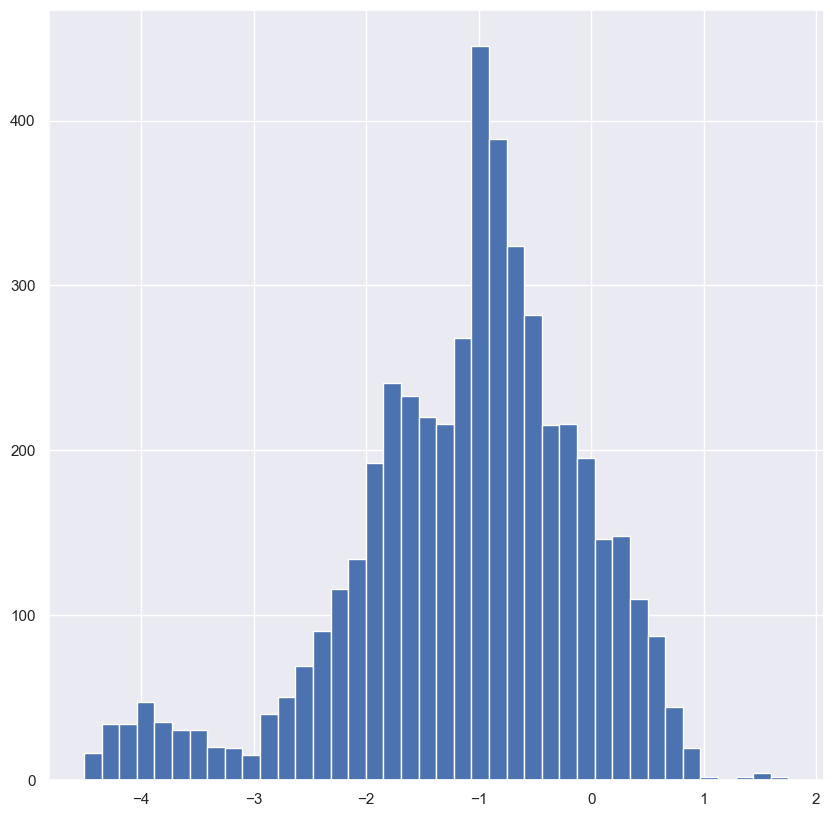

In [ ]:
gen_norm.kg_co2_per_mwh.hist(bins=40)

## Models
### Linear Regression
### Random Forest Regression with hyperparameter optimization and cross validation
### XGBoost Regression with hyperparameter optimization and cross validation
 * Response variable is CO2 Intensity (kg CO2 per MW-hr generated)
 * Explanatory variables are selected features in the following categories: generator configuration (installed capacity by fuel source), specific power, location (geographical average for BA), seasonality, fuel price (natural gas only), BA (categorical)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math
from xgboost import XGBRegressor

def trainLinear(X_train, y_train):
    linearModel = LinearRegression()
    linearModel.fit(X_train, y_train)
    return linearModel

def rfrBaseline(X_train, y_train, rand_st):
    rfr_base = RandomForestRegressor(max_depth=2, min_samples_split=2, n_estimators = 100, random_state=rand_st)
    rfr_base.fit(X_train, y_train)
    return rfr_base

def xgrBaseline(X_train, y_train, rand_st):
    xgr_base = XGBRegressor(max_depth=2, subsample=0.7, colsample_bytree=0.8, eta=0.1, n_estimators = 1000 \
                            , random_state=rand_st)
    xgr_base.fit(X_train, y_train)
    return xgr_base

def rfrTrainTune(X_train, y_train, rand_st):
    rfr = RandomForestRegressor()
    # n_estimators, max_depth, min_samples_split, and max_features are chosen as hyperparameters
    rs = RandomizedSearchCV(rfr, n_iter=10, param_distributions={'n_estimators': range(50,150,5) \
                        , 'max_depth': range(1,30) \
                        , 'min_samples_split':range(2,30) \
                        , 'max_features': ['sqrt', 'log2', None]} \
                        , cv=5, n_jobs=-1, random_state=rand_st)
    rs.fit(X_train, y_train)
    print(f"rs best params:  {rs.best_params_}")
    print(f"rs best score  {rs.best_score_}")
    # apply best hyperparameter values to random forest regression model
    rfr_tuned = RandomForestRegressor(**rs.best_params_, random_state=rand_st)
    # fit tuned model to data set 
    rfr_tuned.fit(X_train, y_train)
    return rfr_tuned, rs.best_params_

def xgrTrainTune(X_train, y_train, param_distributions, rand_st):
    xgr = XGBRegressor()
    rs = RandomizedSearchCV(xgr, n_iter=10, param_distributions=param_distributions \
                        , cv=5, n_jobs=-1, random_state=rand_st)
    rs.fit(X_train, y_train)
    print(f"rs best params:  {rs.best_params_}")
    print(f"rs best score  {rs.best_score_}")
    # apply best hyperparameter values to xgboost regression model
    xgr_tuned = XGBRegressor(**rs.best_params_, random_state=rand_st)
    # fit tuned model to data set 
    xgr_tuned.fit(X_train, y_train)
    return xgr_tuned, rs.best_params_

'''
def rfrParamGrid(coarse_params):
    grid_start = 0.9
    grid_stop = 1.1
    grid_cells_max = 5
    param_grid = {}
    for k in coarse_params.keys():
        try:
            start = math.floor(coarse_params[k]*grid_start)
            if start == 0:
                start = 1
            stop = math.ceil(coarse_params[k]*grid_stop)
            step = math.ceil((stop - start) / grid_cells_max)
            param_grid[k] = range(start,stop,step)
        except TypeError:
            param_grid[k] = [coarse_params[k]]
    print(f"parameter grid:  {param_grid}")
    return param_grid
'''

def createParamGrid(coarse_params, grid_cells_max):
    grid_start = 0.9
    grid_stop = 1.1
    param_grid = {}
    for k in coarse_params.keys():
        try:
            if isinstance(coarse_params[k], int):
                start = math.floor(coarse_params[k]*grid_start)
                if start == 0:
                    start = 1
                stop = math.ceil(coarse_params[k]*grid_stop)
                step = math.ceil((stop - start) / grid_cells_max)
                param_grid[k] = list(set(np.linspace(start, stop, num=grid_cells_max, dtype=int)))
            else:
                start = coarse_params[k]*grid_start
                stop = coarse_params[k]*grid_stop
                step = (stop - start) / grid_cells_max
                param_grid[k] = np.linspace(start,stop,num=grid_cells_max)
        except TypeError:
            param_grid[k] = [coarse_params[k]]
    print(f"parameter grid:  {param_grid}")
    return param_grid

def rfrFineTune(X_train, y_train, param_grid, rand_st):
    rfr = RandomForestRegressor()
    gs = GridSearchCV(rfr, param_grid = param_grid, cv=3, n_jobs=-1, verbose = 2)
    gs.fit(X_train, y_train)
    print(f"grid search best params:  {gs.best_params_}")
    print(f"grid search best score  {gs.best_score_}")
    # apply best hyperparameter values to random forest regression model
    rfr_finetuned = RandomForestRegressor(**gs.best_params_, random_state=rand_st)
    # fit tuned model to data set 
    rfr_finetuned.fit(X_train, y_train)
    return rfr_finetuned  

def xgrFineTune(X_train, y_train, param_grid, rand_st):
    xgr = XGBRegressor()
    gs = GridSearchCV(xgr, param_grid = param_grid, cv=3, n_jobs=-1, verbose = 2)
    gs.fit(X_train, y_train)
    print(f"grid search best params:  {gs.best_params_}")
    print(f"grid search best score  {gs.best_score_}")
    # apply best hyperparameter values to random forest regression model
    xgr_finetuned = XGBRegressor(**gs.best_params_, random_state=rand_st)
    # fit tuned model to data set 
    xgr_finetuned.fit(X_train, y_train)
    return xgr_finetuned

def regrTest(regr_model, X_test, y_test):
    y_pred = regr_model.predict(X_test)
    print("Model Performance:")
    print('    Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred))
    print('    Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
    print('    Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_test, y_pred, squared=False))
    print('    Mean Absolute Percentage Error (MAPE):', 100 * metrics.mean_absolute_percentage_error(y_test, y_pred))
    print('    Explained Variance Score:', metrics.explained_variance_score(y_test, y_pred))
    print('    Max Error:', metrics.max_error(y_test, y_pred))
    #print('    Mean Squared Log Error:', metrics.mean_squared_log_error(y_test, y_pred))
    print('    Median Absolute Error:', metrics.median_absolute_error(y_test, y_pred))
    print('    R^2:', metrics.r2_score(y_test, y_pred))
    #print('    Mean Poisson Deviance:', metrics.mean_poisson_deviance(y_test, y_pred))
    #print(    'Mean Gamma Deviance:', metrics.mean_gamma_deviance(y_test, y_pred))
    return metrics.explained_variance_score(y_test, y_pred)
    
def regrTestTransformed(regr_model, X_test, y_test, y_inv_trans, trans_params):
    y_pred = y_inv_trans(regr_model.predict(X_test), **trans_params)
    y_test = y_test.apply(y_inv_trans, **trans_params)
    print("Model Performance on Untransformed Target:")
    print('    Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred))
    print('    Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
    print('    Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_test, y_pred, squared=False))
    print('    Mean Absolute Percentage Error (MAPE):', 100 * metrics.mean_absolute_percentage_error(y_test, y_pred))
    print('    Explained Variance Score:', metrics.explained_variance_score(y_test, y_pred))
    print('    Max Error:', metrics.max_error(y_test, y_pred))
    #print('    Mean Squared Log Error:', metrics.mean_squared_log_error(y_test, y_pred))
    print('    Median Absolute Error:', metrics.median_absolute_error(y_test, y_pred))
    print('    R^2:', metrics.r2_score(y_test, y_pred))
    #print('    Mean Poisson Deviance:', metrics.mean_poisson_deviance(y_test, y_pred))
    #print(    'Mean Gamma Deviance:', metrics.mean_gamma_deviance(y_test, y_pred))
    return metrics.explained_variance_score(y_test, y_pred)



In [184]:
X = gen[X_names]
y = gen['kg_co2_per_mwh']
rand_st = 3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=rand_st, shuffle=True)

print("Baseline Linear Regression Model")
lr_base = trainLinear(X_train, y_train)
lr_base_score = regrTest(lr_base, X_test, y_test)
print("Baseline Random Forest Regression Model")
rfr_base = rfrBaseline(X_train, y_train, rand_st)
rfr_base_score = regrTest(rfr_base, X_test, y_test)
print("RFR Tuned with Randomized Search CV")
rfr_tuned, rs_params = rfrTrainTune(X_train, y_train, rand_st)
rfr_tuned_score = regrTest(rfr_tuned, X_test, y_test)
print("RFR Fine-tuned with Grid Search CV")
param_grid = createParamGrid(rs_params, 5)
rfr_finetuned = rfrFineTune(X_train, y_train, param_grid, rand_st)
rfr_finetuned_score = regrTest(rfr_finetuned, X_test, y_test)

print("Baseline XGBoost Regression Model")
xgr_base = xgrBaseline(X_train, y_train, rand_st)
xgr_base_score = regrTest(xgr_base, X_test, y_test)
print("XGBoost Regression Tuned with Randomized Search CV")
param_distributions = {'n_estimators': range(500,1500,50) \
                        , 'max_depth': range(1,30) \
                        , 'subsample': np.arange(0.5,1.0,0.1) \
                        , 'colsample_bytree': np.arange(0.5,1.0,0.1) \
                        , 'eta': np.arange(0.01,0.31,0.05)}
xgr_tuned, rs_params = xgrTrainTune(X_train, y_train, param_distributions, rand_st)
xgr_tuned_score = regrTest(xgr_tuned, X_test, y_test)
#xgr_tuned_untransformed_score = regrTestTransformed(xgr_tuned, X_test, y_test, y_inv_trans=unNormShiftLogit, trans_params \
#    ={'lower_bound':0, 'upper_bound':1560, 'shift':0.01})
#print("XGBoost Regression Fine-tuned with Randomized Search CV zoomed on hyperparameters")
#param_distributions = createParamGrid(rs_params, 5)
#xgr_finetuned, rs_params_fine = xgrTrainTune(X_train, y_train, param_distributions, rand_st)
#print("XGBR Fine-tuned with Grid Search CV")
#param_grid = createParamGrid(rs_params, 3)
#xgr_finetuned = xgrFineTune(X_train, y_train, param_grid)
#xgr_finetuned_score = regrTest(xgr_finetuned, X_test, y_test)


Baseline Linear Regression Model
Model Performance:
    Mean Squared Error (MSE): 0.2434323767692932
    Mean Absolute Error (MAE): 0.34283071329103554
    Root Mean Squared Error (RMSE): 0.4933886670458627
    Mean Absolute Percentage Error (MAPE): 192.77618556512564
    Explained Variance Score: 0.7771779009297491
    Max Error: 2.0953733361914777
    Median Absolute Error: 0.24339494628070302
    R^2: 0.776986270883347
Baseline Random Forest Regression Model
Model Performance:
    Mean Squared Error (MSE): 0.47962588724704786
    Mean Absolute Error (MAE): 0.5101398396460118
    Root Mean Squared Error (RMSE): 0.6925502777755908
    Mean Absolute Percentage Error (MAPE): 285.37380915877566
    Explained Variance Score: 0.5607504185385994
    Max Error: 2.3760429390370956
    Median Absolute Error: 0.3974716657900127
    R^2: 0.5606042256358567
RFR Tuned with Randomized Search CV
rs best params:  {'n_estimators': 75, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 16}
r

In [185]:
def calcResiduals(dataset, model, exp_var_names, resp_var_name):
    dataset_check = dataset.copy()
    dataset_check[f"predicted_{resp_var_name}"] = model.predict(dataset_check[exp_var_names])
    dataset_check['residual'] = dataset_check[resp_var_name] - dataset_check[f"predicted_{resp_var_name}"]
    #res_mean = dataset_check['residual'].mean()
    res_stdev = dataset_check['residual'].std()
    dataset_check['std_residual'] = dataset_check['residual'] / res_stdev
    return dataset_check
    

<Axes: xlabel='predicted_kg_co2_per_mwh_nsl', ylabel='std_residual'>

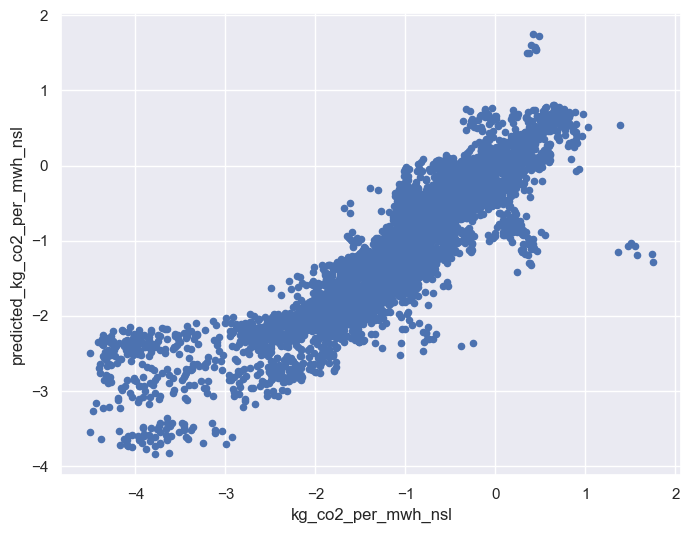

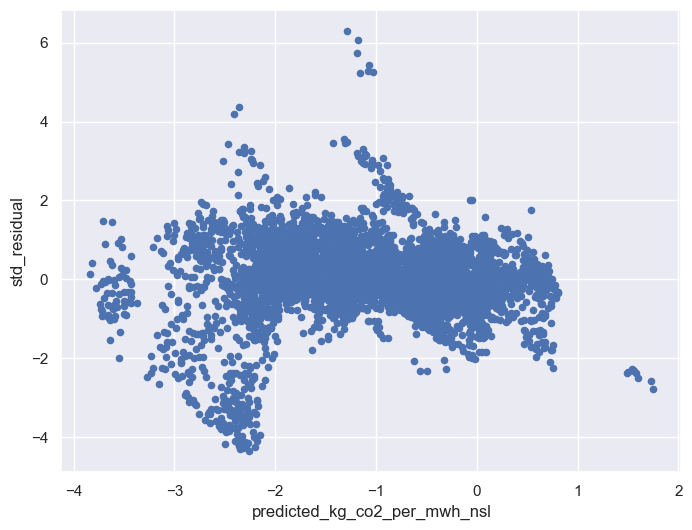

In [186]:

sns.set(rc={'figure.figsize':(8,6)})
resp_var_name = 'kg_co2_per_mwh_nsl'
lr_res = calcResiduals(gen_norm, lr_base, X_names, resp_var_name)
lr_res.plot.scatter(x=resp_var_name, y=f"predicted_{resp_var_name}")
lr_res.plot.scatter(x=f"predicted_{resp_var_name}", y='std_residual')

<Axes: xlabel='predicted_kg_co2_per_mwh_nsl', ylabel='std_residual'>

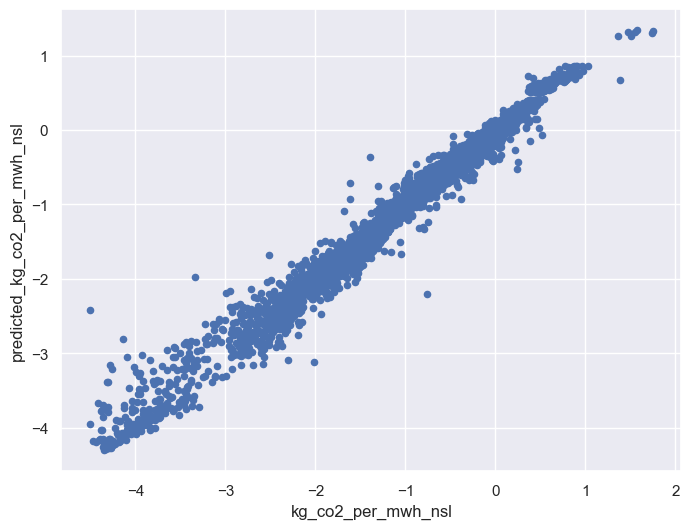

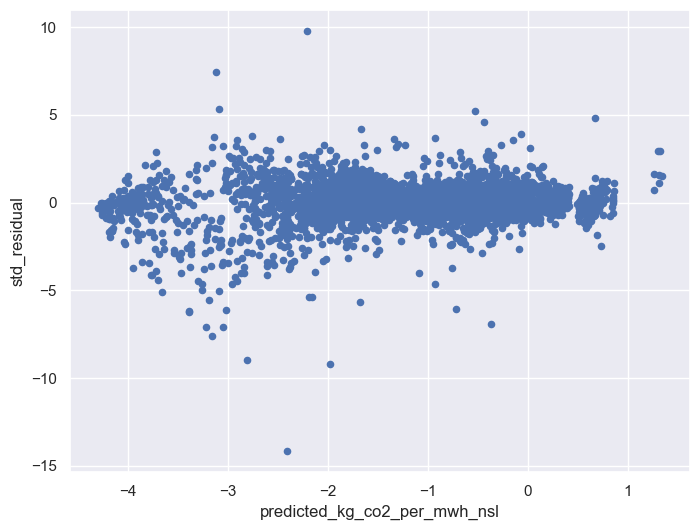

In [187]:
rfr_res = calcResiduals(gen_norm, rfr_finetuned, X_names, resp_var_name)
rfr_res.plot.scatter(x=resp_var_name, y=f"predicted_{resp_var_name}")
rfr_res.plot.scatter(x=f"predicted_{resp_var_name}", y='std_residual')

<Axes: xlabel='predicted_kg_co2_per_mwh_nsl', ylabel='std_residual'>

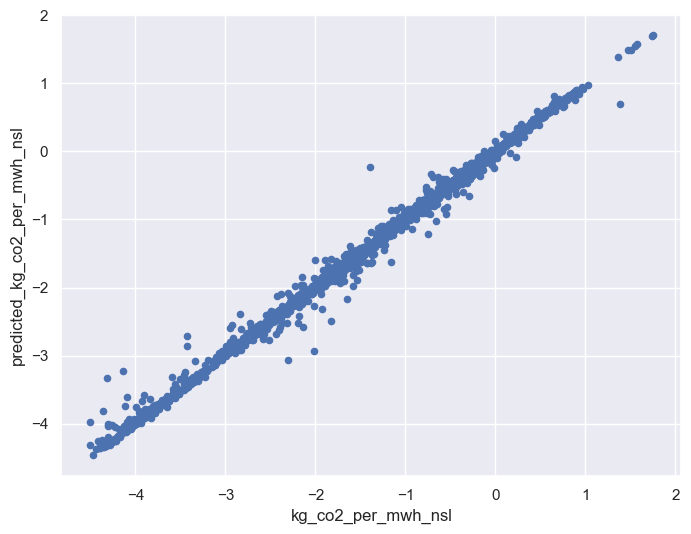

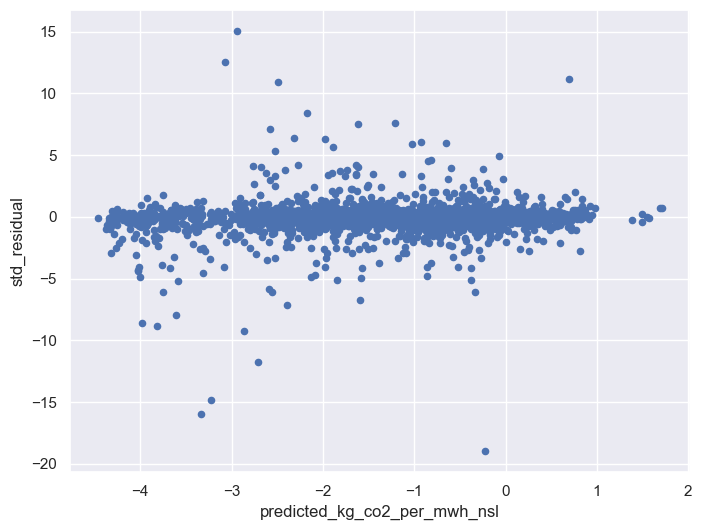

In [188]:
xgr_res = calcResiduals(gen_norm, xgr_tuned, X_names, resp_var_name)
xgr_res.plot.scatter(x=resp_var_name, y=f"predicted_{resp_var_name}")
xgr_res.plot.scatter(x=f"predicted_{resp_var_name}", y='std_residual')

<Axes: xlabel='kg_co2_per_mwh', ylabel='predicted_kg_co2_per_mwh'>

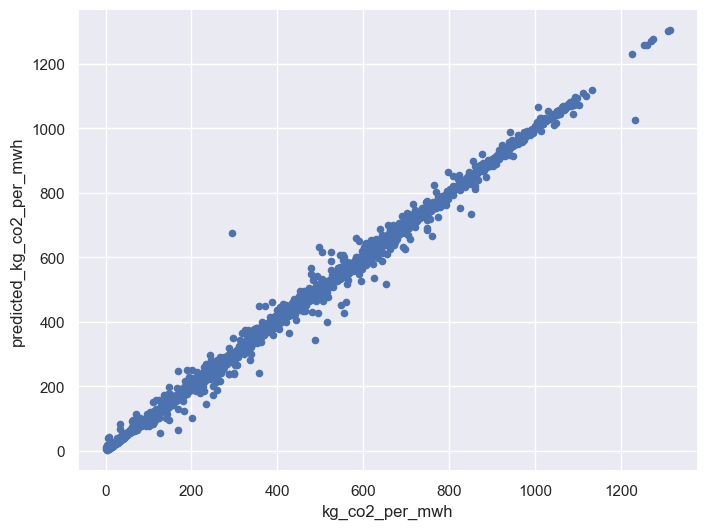

In [189]:
xgr_res['predicted_kg_co2_per_mwh'] = xgr_res['predicted_kg_co2_per_mwh_nsl'].apply(unNormShiftLogit, lower_bound=0 \
    , upper_bound=1560, shift=.01)
xgr_res.plot.scatter(x='kg_co2_per_mwh', y='predicted_kg_co2_per_mwh')
#xgr_res.plot.scatter(x=f"predicted_{resp_var_name}", y='std_residual')

In [190]:
print(xgr_res[xgr_res.std_residual < -20].T)
with open('view_output.txt', 'w') as outfile:
    xgr_res[xgr_res.std_residual < -20].T.to_csv(outfile)

Empty DataFrame
Columns: []
Index: [ba_code, index, period, av_lat, av_lon, BIT, DFO, GEO, JF, KER, LIG, MSW, NG, NUC, OTH, PC, PG, RC, RFO, SGC, SGP, SUB, SUN, TDF, WAT, WC, WND, WO, gen_mwh, co2_kton, kg_co2_per_mwh, total_cap_mw, NG_price, avg_mw_per_cap, sin_year, cos_year, sin_6mo, cos_6mo, log_BIT, log_DFO, log_GEO, log_JF, log_KER, log_LIG, log_MSW, log_NG, log_NUC, log_OTH, log_PC, log_PG, log_RC, log_RFO, log_SGC, log_SGP, log_SUB, log_SUN, log_TDF, log_WAT, log_WC, log_WND, log_WO, log_NG_price, log_avg_mw_per_cap, kg_co2_per_mwh_nsl, predicted_kg_co2_per_mwh_nsl, residual, std_residual, predicted_kg_co2_per_mwh]

[68 rows x 0 columns]


<Axes: xlabel='period'>

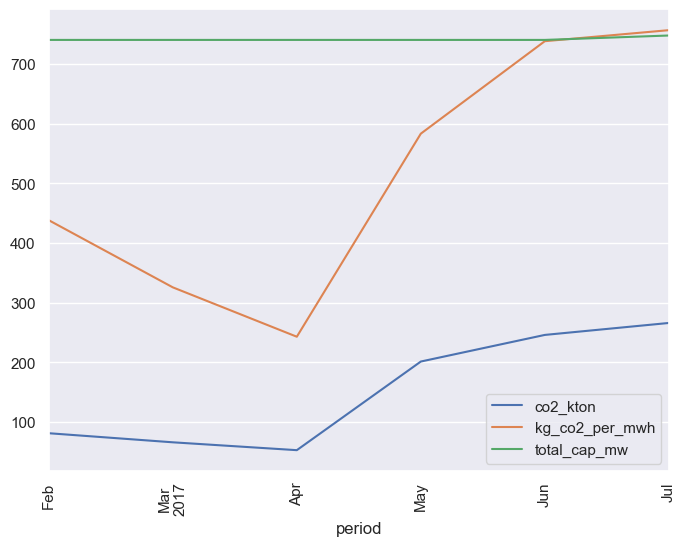

In [191]:
gen_norm[(gen_norm.ba_code == 'GVL') & (gen_norm.period > '2017-01-01') & (gen_norm.period < '2017-08-01')] \
    [['period','co2_kton','kg_co2_per_mwh','total_cap_mw']].plot(x='period',rot=90)

<Axes: xlabel='std_residual', ylabel='Count'>

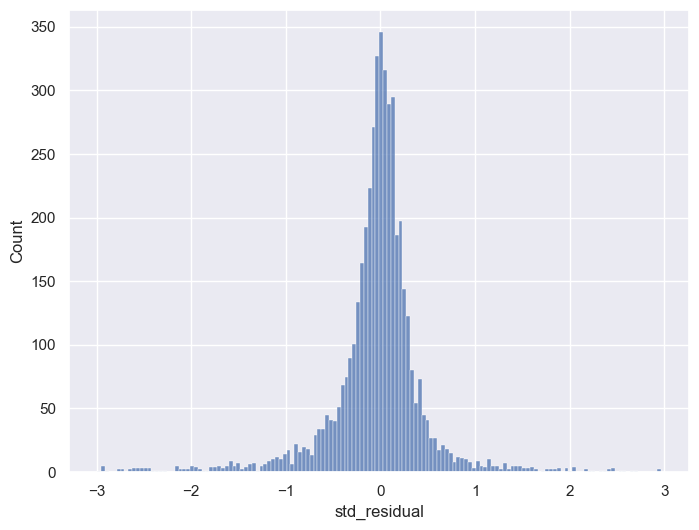

In [192]:
#xgr_res['std_residual'].hist(bins=500)
sns.histplot(data=xgr_res[(xgr_res.std_residual > -3) & (xgr_res.std_residual < 3)], x='std_residual')
#plt.ylim(0,100)
#plt.show()

In [193]:
from scipy.stats import skew, skewtest
skew(xgr_res['std_residual'])

-1.9723829988246635

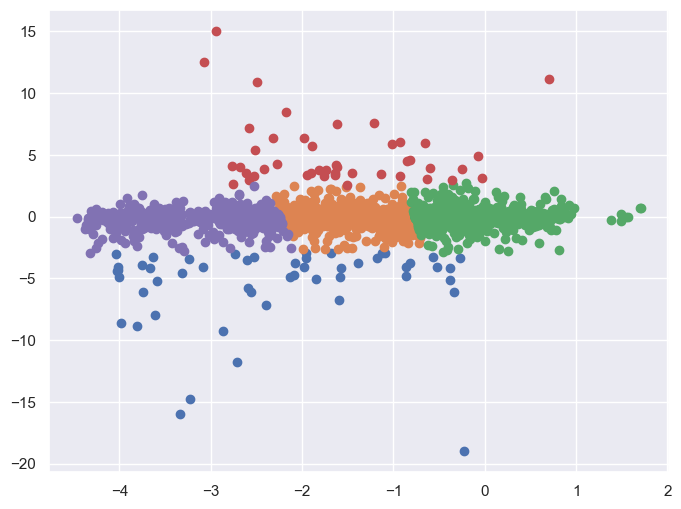

In [194]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 5, random_state=rand_st, n_init='auto')
label = kmeans.fit_predict(xgr_res[['predicted_kg_co2_per_mwh_nsl','std_residual']])
xgr_res['label'] = label

#.select_dtypes(include=np.number)
labels = np.unique(label)
for i in labels:
    plt.scatter(xgr_res[xgr_res.label == i]['predicted_kg_co2_per_mwh_nsl'], xgr_res[xgr_res.label == i]['std_residual'])
plt.show()


[['AEC', 1.530388749400491], ['AECI', 1.9438027342069353], ['AVA', 1.4572639818526907], ['AZPS', 2.0812089392185245], ['BANC', 1.5168605811695803], ['BPAT', 1.7421674745365212], ['CISO', 1.6183681832499892], ['CPLE', 1.9507107654316782], ['DEAA', 2.367835796684673], ['DUK', 1.699989045938242], ['EEI', 1.7631019123136542], ['EPE', 1.6156065729193771], ['ERCO', 2.1320399979899225], ['FMPP', 1.924884696154423], ['FPC', 1.6344475662051887], ['FPL', 1.922208283527446], ['GRIF', 2.1957989633846133], ['GRMA', 2.0156344831417714], ['GVL', 1.4363155987895244], ['HGMA', 1.6409567340619375], ['HST', 1.8510084219782805], ['IID', 1.9794739683190725], ['IPCO', 1.7790433747908259], ['ISNE', 1.573242974321601], ['JEA', 1.963208607201337], ['LDWP', 1.6997219073827592], ['LGEE', 1.8582169214404403], ['MISO', 1.2660569032006417], ['NEVP', 1.5678396527411331], ['NWMT', 1.919462322291506], ['NYIS', 1.7517296087593224], ['OVEC', 1.8878183998019666], ['PACE', 1.3344361697113125], ['PACW', 1.8734147466135247]

array([[<Axes: title={'center': '1'}>]], dtype=object)

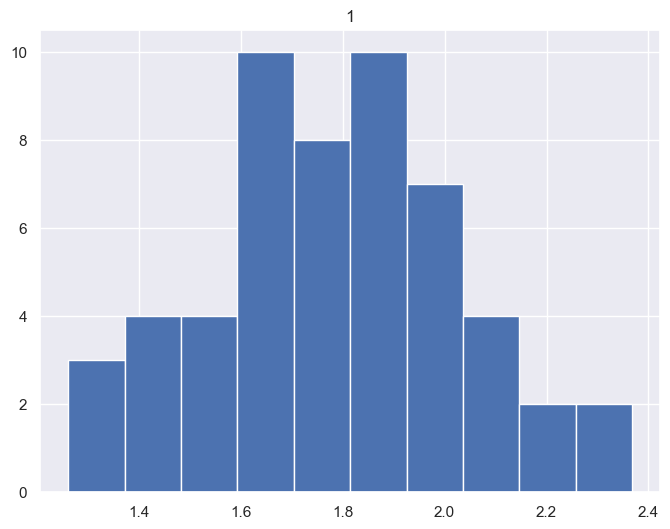

In [195]:
# check for autocorrelation between residuals
from statsmodels.stats.stattools import durbin_watson
#print(durbin_watson(xgr_res['residual'])) #probably not valid since there are multiple records per time
dw_by_ba = []
for ba in xgr_res.ba_code.unique():
    #print(ba)
    #print(f"  {durbin_watson(xgr_res[xgr_res.ba_code == ba]['residual'])}")
    dw_by_ba.append([ba, durbin_watson(xgr_res[xgr_res.ba_code == ba]['residual'])])
print(dw_by_ba)
dw_check = pd.DataFrame(dw_by_ba)
dw_check.hist()


In [196]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(rfr_finetuned.estimators_[0], feature_names=X_names, filled=True, rounded=True)
graph = graphviz.Source(dot_data, format='png')
graph.render('tree', view=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.8016 to fit


'tree.png'

In [197]:
xgr_tuned.feature_importances_

array([6.48739096e-03, 1.39605245e-02, 1.09498706e-02, 1.96717889e-03,
       5.04020276e-03, 4.17407806e-04, 3.64936830e-04, 6.49143662e-03,
       1.15551765e-03, 1.84806846e-02, 4.32456993e-02, 8.10552202e-03,
       1.77436043e-02, 3.14501510e-03, 2.16733534e-02, 3.53160169e-04,
       4.11131012e-04, 9.76459996e-04, 1.17636500e-02, 1.90156954e-03,
       3.21943167e-04, 1.69318751e-01, 2.72514136e-03, 3.00707994e-03,
       1.63691162e-04, 5.62057423e-04, 5.96721796e-03, 2.34869681e-03,
       8.40725144e-04, 7.03082478e-04, 8.16017739e-04, 5.73328137e-02,
       8.56377929e-03, 2.02708598e-03, 7.30839558e-04, 1.92312151e-03,
       8.09056626e-04, 1.45000685e-03, 6.06742240e-02, 7.50329792e-02,
       4.15855832e-03, 7.05275743e-04, 0.00000000e+00, 7.68017247e-02,
       4.55096189e-04, 1.01579666e-04, 2.06275377e-03, 1.15805119e-02,
       2.55267206e-03, 4.21197910e-04, 3.14412266e-01, 2.88881338e-03,
       2.54065101e-03, 1.67466613e-04, 9.58762364e-04, 1.02399681e-02],
     

<Axes: title={'center': 'Random Forest Regression Feature Importance'}, ylabel='feature'>

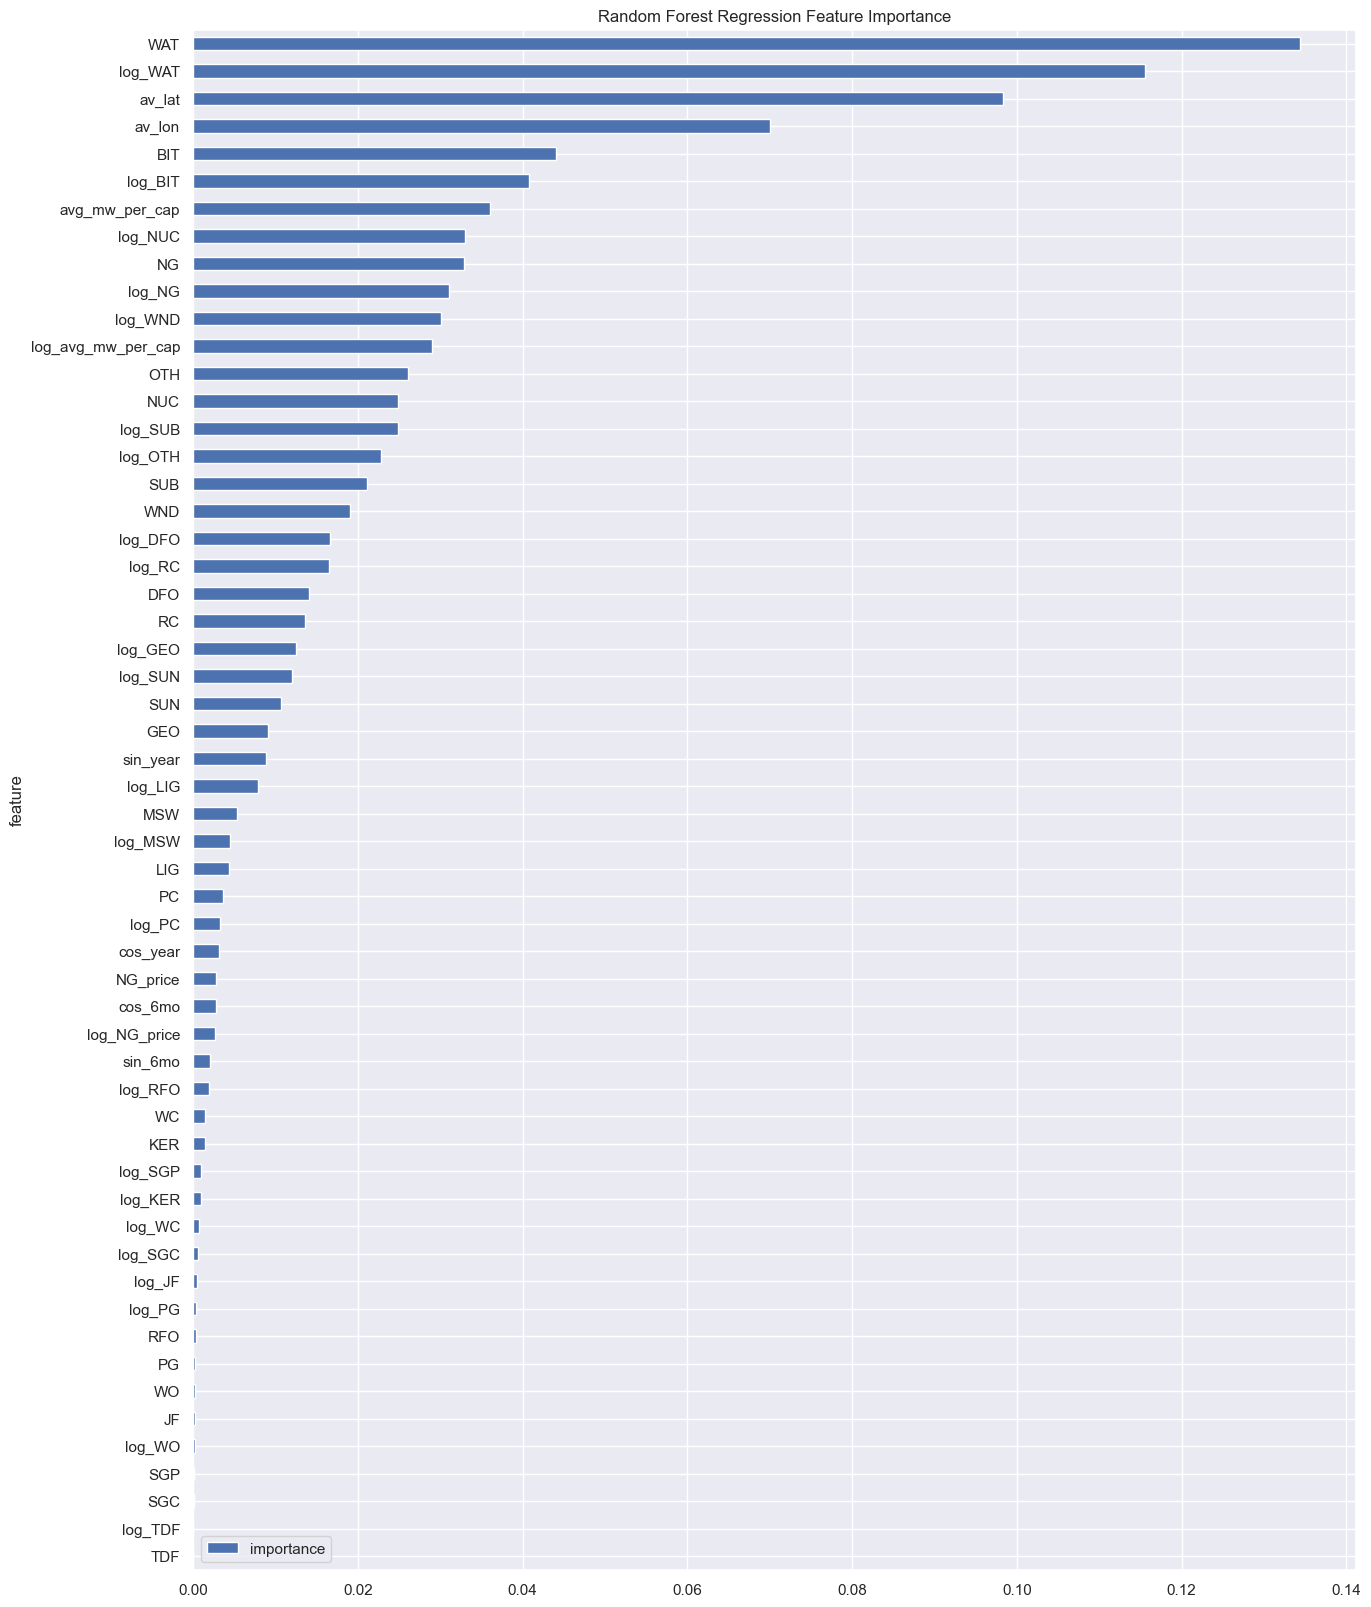

In [198]:
fx_imp = pd.DataFrame({'feature': X_names, 'importance': rfr_finetuned.feature_importances_})
fx_imp = fx_imp.sort_values(by='importance')
fx_imp.plot.barh(x='feature', y='importance', figsize=(15,20), title="Random Forest Regression Feature Importance")

<Axes: title={'center': 'XGBoost Regression Feature Importance'}, ylabel='feature'>

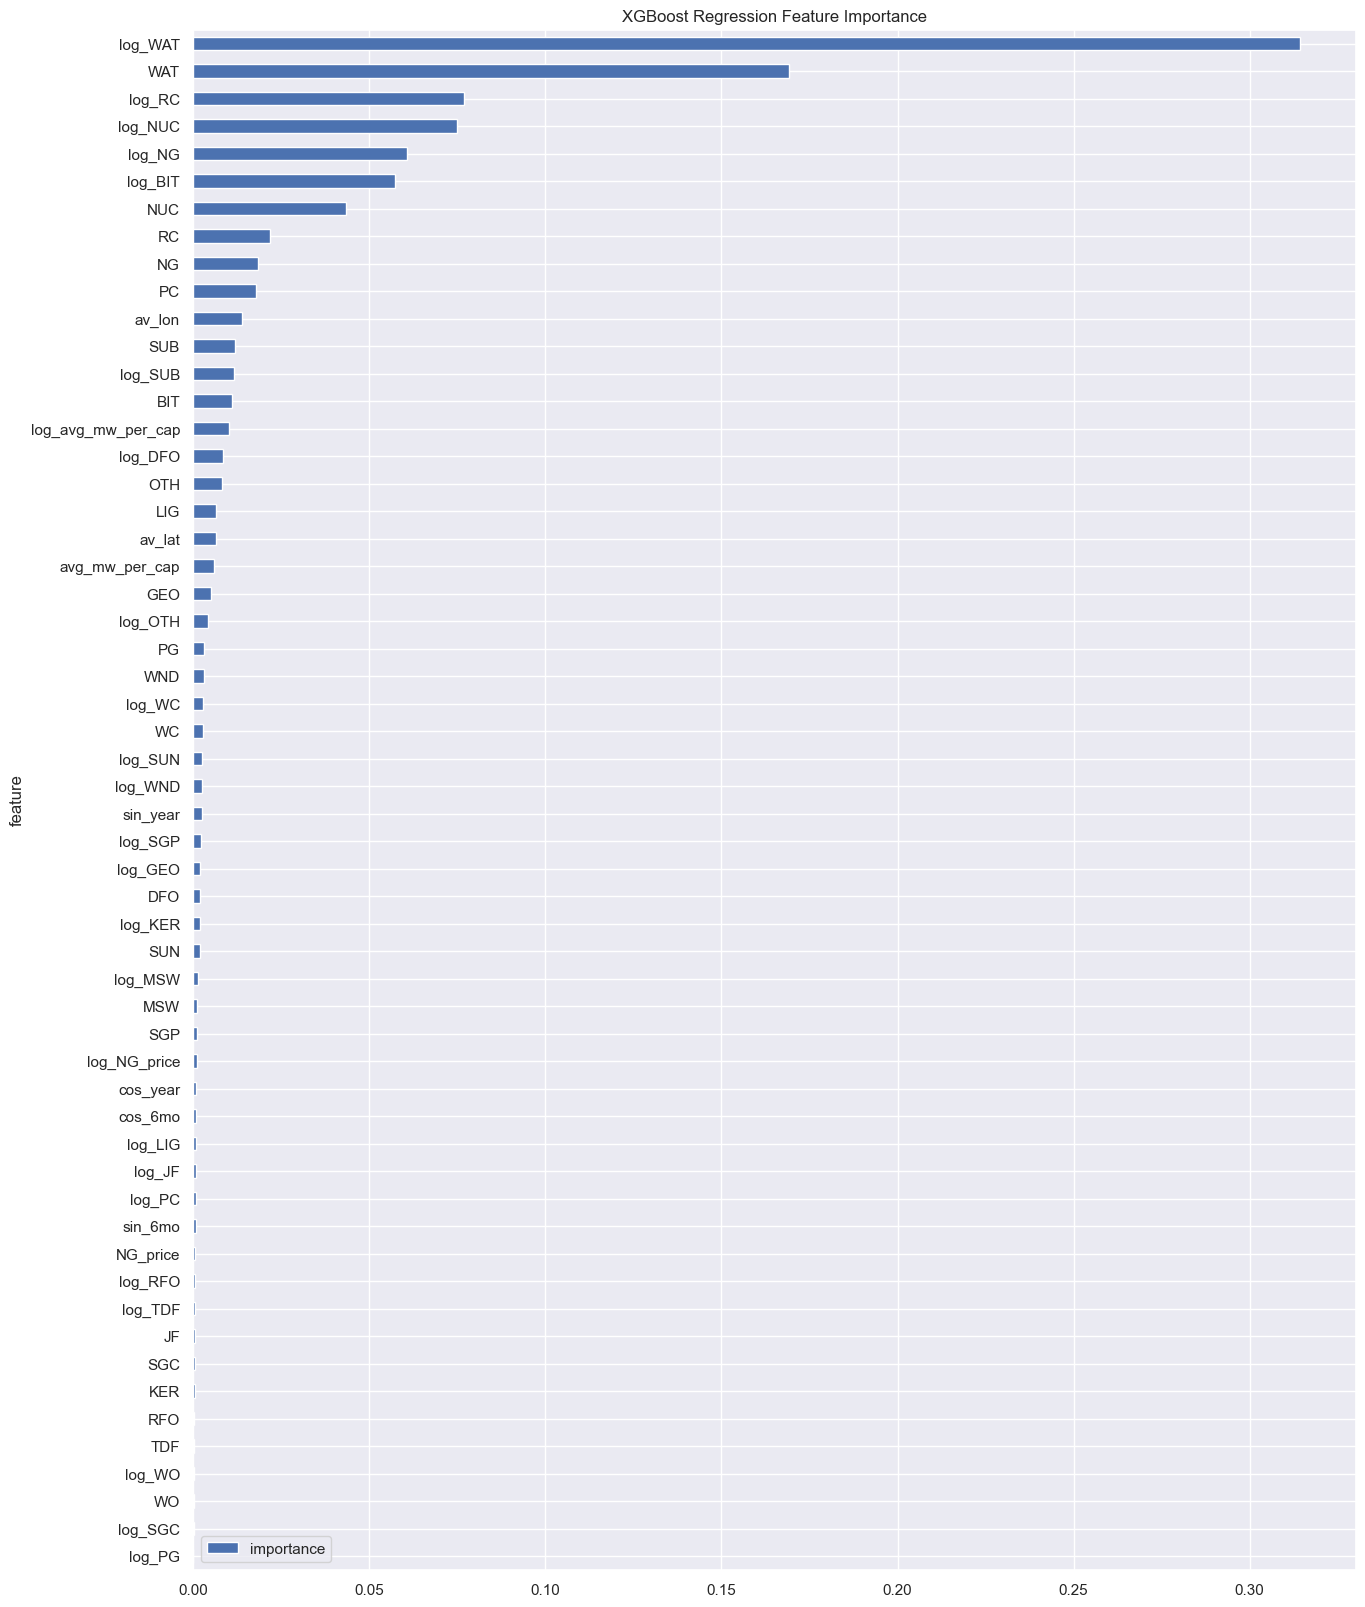

In [199]:
fx_imp = pd.DataFrame({'feature': X_names, 'importance': xgr_tuned.feature_importances_})
fx_imp = fx_imp.sort_values(by='importance')
fx_imp.plot.barh(x='feature', y='importance', figsize=(15,20), title='XGBoost Regression Feature Importance')

## Use model to predict how adding 100 MW of solar generation capacity to a Balancing Authority would affect CO2 emissions

In [200]:
# average most recent two years of reliable configuration data to approximate current configuration (2020 and 2021)
# same for gen_mwh to approximate future generation (~demand)? Or use more years for smoothing?

add_solar_mw = 100
add_wind_mw = 0

In [201]:
def getGenData(explan_path, resp_path, data_cutoff):
    genconf = pd.read_csv(explan_path, low_memory=False)
    genout = pd.read_csv(resp_path, low_memory=False)
    # EIA data is not finalized until fall of the year following the reporting period, so cut off data at end of 2021
    genconf = genconf[genconf.period < data_cutoff]
    #genout = genout[genout.period < data_cutoff]
    return genconf, genout

In [202]:
def addNotionalCapacity(genconf, add_solar_mw, add_wind_mw):
    genconf['SUN'] += add_solar_mw
    genconf['WND'] += add_wind_mw
    return genconf

In [203]:
def prepFeaturesAndTarget(genconf, genout):
    # calculate total generation capacity per row
    genconf['total_cap_mw'] = genconf.drop(['av_lat','av_lon'], axis=1).sum(axis=1, numeric_only=True)
    # divide capacity per energy source by total capacity
    genconf_norm = genconf[['ba_code','period','av_lat','av_lon','total_cap_mw']].join(genconf.drop(['av_lat','av_lon'], axis=1).select_dtypes \
                                                                   (include=np.number).apply(lambda x : x/genconf['total_cap_mw']) \
                                                                    .drop(columns=['total_cap_mw']))
    #normalize latitude to range 0,1
    genconf_norm['av_lat'] = genconf_norm['av_lat'].apply(lambda x: (x-genconf_norm['av_lat'].min())/(genconf_norm['av_lat'].max() \
                                                                           - genconf_norm['av_lat'].min()))
    #normalize longitude to range 0,1
    genconf_norm['av_lon'] = genconf_norm['av_lon'].apply(lambda x: (x-genconf_norm['av_lon'].min())/(genconf_norm['av_lon'].max() \
                                                                           - genconf_norm['av_lon'].min()))
    
    genout = genout[['ba_code', 'period', 'gen_mwh', 'co2_kton', 'kg_co2_per_mwh']]
    genout_norm = genout.set_index(['ba_code','period']).join(genconf[['ba_code','period','total_cap_mw']].set_index(['ba_code','period']))
    genout_norm.dropna()
    # normalize using capacity * time, i.e. how much could a BA generate in a month if 
    # running all generators at 100% capacity
    # using 31 days per month in an effort to keep result <= 1.
    genout_norm['avg_mw_per_cap'] = genout_norm['gen_mwh']/(genout_norm['total_cap_mw']*31*24)
    genout_norm = genout_norm.reset_index()
    # remove rows with nonsense generation values (generation exceeds reported capacity)
    genout_norm = genout_norm[genout_norm.avg_mw_per_cap <= 1]
    gen_norm = genconf_norm.drop(columns='total_cap_mw').set_index(['ba_code', 'period']).join(genout_norm \
                                                                  .set_index(['ba_code', 'period']))
    gen_norm = gen_norm.reset_index()
    
    ng_price_path = 'NG_price.csv'
    ng_price = pd.read_csv(ng_price_path, low_memory=False)
    ng_price.head()
    gen_norm = gen_norm.set_index(['period']).join(ng_price.set_index('period')).reset_index()
    print(gen_norm.shape)
    gen_norm = gen_norm.dropna()
    print(gen_norm.shape)
    gen_norm = gen_norm.reset_index()
    move_col = gen_norm.pop('ba_code')
    gen_norm.insert(0, move_col.name, move_col)
    move_col = gen_norm.pop('NG_price')
    gen_norm.insert(gen_norm.columns.get_loc('avg_mw_per_cap'), move_col.name, move_col)
    # normalize natural gas price
    gen_norm['NG_price'] = (gen_norm['NG_price'] - gen_norm['NG_price'].min())/(gen_norm['NG_price'].max() \
        - gen_norm['NG_price'].min())
    gen_norm = gen_norm.sort_values(by=['ba_code','period'])
    gen_norm = gen_norm[gen_norm.kg_co2_per_mwh >= 0]
    
    gen_norm['period'] = pd.to_datetime(gen_norm['period'])
    # create Julian date column (days since noon on 1 Jan 4713 BC)
    gen_norm['julian'] = gen_norm['period'].apply(lambda x : pd.Timestamp(x).to_julian_date())
    # create sine and cosine of time features
    gen_norm['sin_year'] = np.sin(gen_norm['julian'] / 365.25 * 2 * np.pi)
    gen_norm['cos_year'] = np.cos(gen_norm['julian'] / 365.25 * 2 * np.pi)
    gen_norm['sin_6mo'] = np.sin(gen_norm['julian'] / (365.25/2) * 2 * np.pi)
    gen_norm['cos_6mo'] = np.cos(gen_norm['julian'] / (365.25/2) * 2 * np.pi)
    gen_norm = gen_norm.drop(columns=['julian'])
    not_features = ['ba_code', 'index', 'period', 'kg_co2_per_mwh', 'gen_mwh', 'co2_kton', 'total_cap_mw',]
    X_names = [i for i in list(gen_norm.columns.values) if i not in not_features]
    # list feature names to log transform
    no_log = ['av_lat', 'av_lon', 'sin_year', 'cos_year', 'sin_6mo', 'cos_6mo']
    X_to_log = [i for i in X_names if i not in no_log]
    X_log_names = [f"log_{i}" for i in X_to_log]
    gen_norm[X_log_names] = gen_norm[X_to_log].apply(lambda x: np.log(1+x))
    #X_names = [i for i in list(gen_norm.columns.values) if i not in not_features]
    return gen_norm


In [204]:
genconfig, genoutput = getGenData(explan_path, resp_path, data_cutoff)
genconf_hyp = addNotionalCapacity(genconfig, add_solar_mw, add_wind_mw)
gen_hyp = prepFeaturesAndTarget(genconf_hyp, genoutput)
gen_hyp.head()

(6996, 33)
(4880, 33)


,ba_code,index,period,av_lat,av_lon,BIT,DFO,GEO,JF,KER,...,log_SGP,log_SUB,log_SUN,log_TDF,log_WAT,log_WC,log_WND,log_WO,log_NG_price,log_avg_mw_per_cap
0,AEC,0,2013-01-01,0.247954,0.704774,0.27158,0.0,0.0,0.0,0.0,...,0.0,0.0,0.049247,0.0,0.004131,0.0,0.0,0.0,0.328596,0.460054
45,AEC,63,2013-02-01,0.247954,0.704774,0.27158,0.0,0.0,0.0,0.0,...,0.0,0.0,0.049247,0.0,0.004131,0.0,0.0,0.0,0.328596,0.445811
93,AEC,126,2013-03-01,0.247954,0.704774,0.27158,0.0,0.0,0.0,0.0,...,0.0,0.0,0.049247,0.0,0.004131,0.0,0.0,0.0,0.404702,0.468948
138,AEC,189,2013-04-01,0.247954,0.704774,0.27158,0.0,0.0,0.0,0.0,...,0.0,0.0,0.049247,0.0,0.004131,0.0,0.0,0.0,0.458207,0.370073
188,AEC,252,2013-05-01,0.247954,0.704774,0.27158,0.0,0.0,0.0,0.0,...,0.0,0.0,0.049247,0.0,0.004131,0.0,0.0,0.0,0.439214,0.332300


In [205]:
gen_hyp.shape

(4880, 63)

In [206]:
#set feature variables to reflect current conditions, i.e. configuration of BAs
curr_start = '2021-01-01'
curr_end = '2022-01-01'

gen_hyp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4880 entries, 0 to 1111
Data columns (total 63 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ba_code             4880 non-null   object        
 1   index               4880 non-null   int64         
 2   period              4880 non-null   datetime64[ns]
 3   av_lat              4880 non-null   float64       
 4   av_lon              4880 non-null   float64       
 5   BIT                 4880 non-null   float64       
 6   DFO                 4880 non-null   float64       
 7   GEO                 4880 non-null   float64       
 8   JF                  4880 non-null   float64       
 9   KER                 4880 non-null   float64       
 10  LIG                 4880 non-null   float64       
 11  MSW                 4880 non-null   float64       
 12  NG                  4880 non-null   float64       
 13  NUC                 4880 non-null   float64       
 1

In [207]:
gen_hyp.shape

(4880, 63)

In [208]:
gen_norm.shape

(4779, 64)

In [209]:
gen_hyp = gen_norm.set_index(['ba_code', 'period'])[['BIT']].join(gen_hyp.set_index(['ba_code', 'period']), rsuffix='drop') \
    .drop(columns=['BITdrop']).reset_index()

In [210]:
gen_hyp.shape

(4779, 63)

In [211]:
gen_hyp.head()

,ba_code,period,BIT,index,av_lat,av_lon,DFO,GEO,JF,KER,...,log_SGP,log_SUB,log_SUN,log_TDF,log_WAT,log_WC,log_WND,log_WO,log_NG_price,log_avg_mw_per_cap
0,AEC,2013-01-01,0.286018,0,0.247954,0.704774,0.0,0.0,0.0,0.0,...,0.0,0.0,0.049247,0.0,0.004131,0.0,0.0,0.0,0.328596,0.460054
1,AEC,2013-02-01,0.286018,63,0.247954,0.704774,0.0,0.0,0.0,0.0,...,0.0,0.0,0.049247,0.0,0.004131,0.0,0.0,0.0,0.328596,0.445811
2,AEC,2013-03-01,0.286018,126,0.247954,0.704774,0.0,0.0,0.0,0.0,...,0.0,0.0,0.049247,0.0,0.004131,0.0,0.0,0.0,0.404702,0.468948
3,AEC,2013-04-01,0.286018,189,0.247954,0.704774,0.0,0.0,0.0,0.0,...,0.0,0.0,0.049247,0.0,0.004131,0.0,0.0,0.0,0.458207,0.370073
4,AEC,2013-05-01,0.286018,252,0.247954,0.704774,0.0,0.0,0.0,0.0,...,0.0,0.0,0.049247,0.0,0.004131,0.0,0.0,0.0,0.439214,0.332300


In [212]:
gen_hyp['kg_co2_per_mwh_hyp_pred'] = xgr_tuned.predict(gen_hyp[X_names])
gen_hyp['kg_co2_per_mwh_curr_pred'] = xgr_tuned.predict(gen_norm[X_names])


In [213]:
gen_hyp['kg_co2_per_mwh_hyp_pred'] = gen_hyp['kg_co2_per_mwh_hyp_pred'].apply(unNormShiftLogit, lower_bound=0 \
    , upper_bound=1560, shift=.01)
gen_hyp['kg_co2_per_mwh_curr_pred'] = gen_hyp['kg_co2_per_mwh_curr_pred'].apply(unNormShiftLogit, lower_bound=0 \
    , upper_bound=1560, shift=.01)

In [214]:
gen_hyp['co2_kton_curr_pred'] = gen_hyp['gen_mwh'] * gen_hyp['kg_co2_per_mwh_curr_pred'] / 1e6
gen_hyp['co2_kton_hyp_pred'] = gen_hyp['gen_mwh'] * gen_hyp['kg_co2_per_mwh_hyp_pred'] / 1e6
#gen_hyp = gen_hyp[(gen_hyp.period > curr_start) & (gen_hyp.period <= curr_end)]

In [215]:
gen_hyp['month'] = gen_hyp['period'].apply(lambda m : pd.to_datetime(m).month)
gen_hyp = gen_hyp.drop(columns='period').groupby(['ba_code', 'month']).mean().reset_index()
gen_hyp.head()

,ba_code,month,BIT,index,av_lat,av_lon,DFO,GEO,JF,KER,...,log_WAT,log_WC,log_WND,log_WO,log_NG_price,log_avg_mw_per_cap,kg_co2_per_mwh_hyp_pred,kg_co2_per_mwh_curr_pred,co2_kton_curr_pred,co2_kton_hyp_pred
0,AEC,1,0.254238,3097.333333,0.247954,0.704774,0.0,0.0,0.0,0.0,...,0.004301,0.0,0.0,0.0,0.289683,0.519044,499.260315,523.146898,517.944304,492.491415
1,AEC,2,0.254238,3162.111111,0.247954,0.704774,0.0,0.0,0.0,0.0,...,0.004301,0.0,0.0,0.0,0.300616,0.455967,478.239360,491.643965,408.088248,394.552287
2,AEC,3,0.254238,3226.888889,0.247954,0.704774,0.0,0.0,0.0,0.0,...,0.004301,0.0,0.0,0.0,0.244605,0.451574,475.469395,493.588259,402.577304,387.067757
3,AEC,4,0.254238,3291.666667,0.247954,0.704774,0.0,0.0,0.0,0.0,...,0.004301,0.0,0.0,0.0,0.247221,0.387864,511.136677,542.985663,367.900336,346.980083
4,AEC,5,0.254238,3356.444444,0.247954,0.704774,0.0,0.0,0.0,0.0,...,0.004301,0.0,0.0,0.0,0.254796,0.474733,518.238665,570.537854,482.326543,441.656893


<Axes: xlabel='month'>

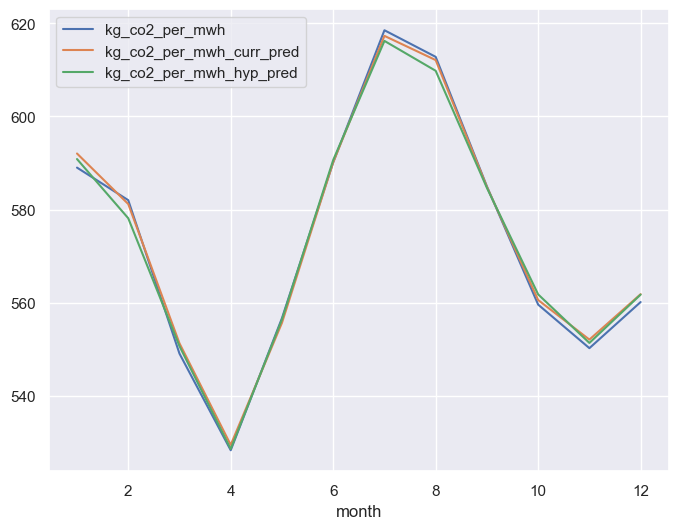

In [216]:
gen_hyp[gen_hyp.ba_code == 'MISO'].set_index('month')[['kg_co2_per_mwh', \
                        'kg_co2_per_mwh_curr_pred', 'kg_co2_per_mwh_hyp_pred']].plot()

<Axes: xlabel='month'>

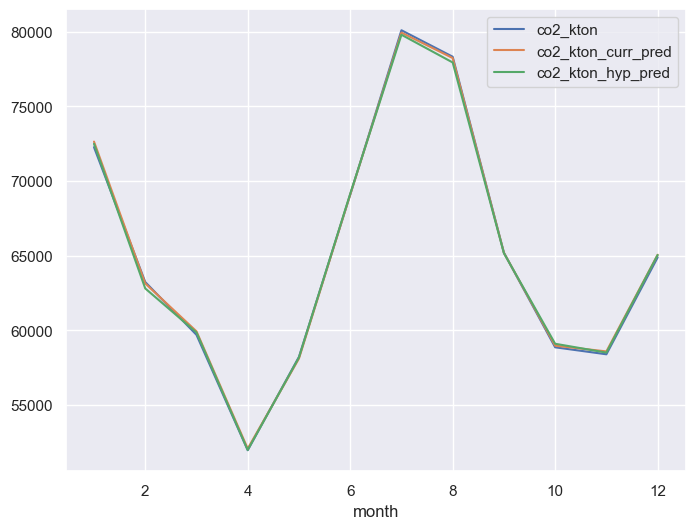

In [217]:
gen_hyp[gen_hyp.ba_code == 'MISO'].set_index('month')[['co2_kton','co2_kton_curr_pred' \
                                                       , 'co2_kton_hyp_pred']].plot()

<Axes: xlabel='month'>

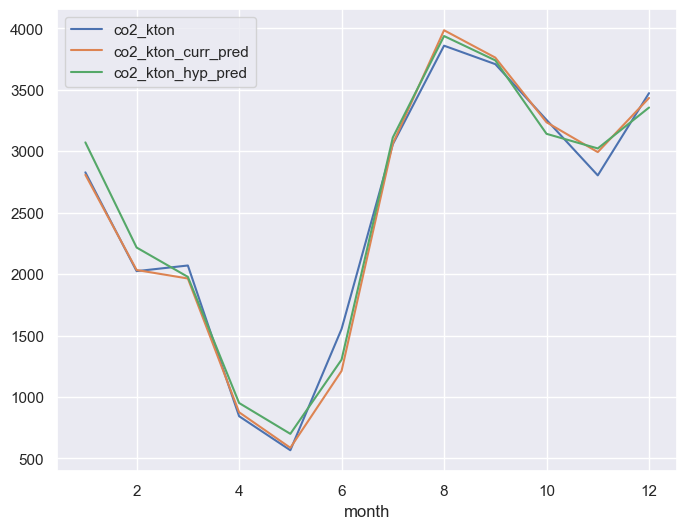

In [218]:
gen_hyp[gen_hyp.ba_code == 'BPAT'].set_index('month')[['co2_kton','co2_kton_curr_pred' \
                                                       , 'co2_kton_hyp_pred']].plot()

<Axes: xlabel='month'>

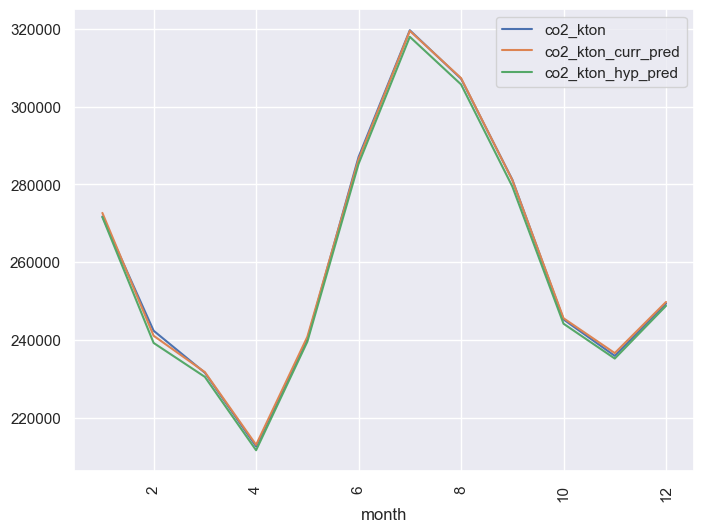

In [219]:
gen_hyp.groupby('month').sum()[['co2_kton','co2_kton_curr_pred', 'co2_kton_hyp_pred']].plot(rot=90)

In [220]:
co2_annual = gen_hyp.groupby('ba_code')[['co2_kton','co2_kton_curr_pred', 'co2_kton_hyp_pred']].sum()
co2_annual['delta_co2_kton_pred'] = co2_annual['co2_kton_hyp_pred'] - co2_annual['co2_kton_curr_pred']
co2_annual.head()

,co2_kton,co2_kton_curr_pred,co2_kton_hyp_pred,delta_co2_kton_pred
ba_code,,,,
AEC,5937.617863,5915.619077,5518.285402,-397.333674
AECI,32743.805163,32722.499824,30952.429475,-1770.070348
AVA,1374.714470,1367.718227,1494.978964,127.260737
AZPS,28582.572574,28576.549844,28161.381531,-415.168312
BANC,5108.794062,5116.606593,4979.252099,-137.354495


<Axes: ylabel='ba_code'>

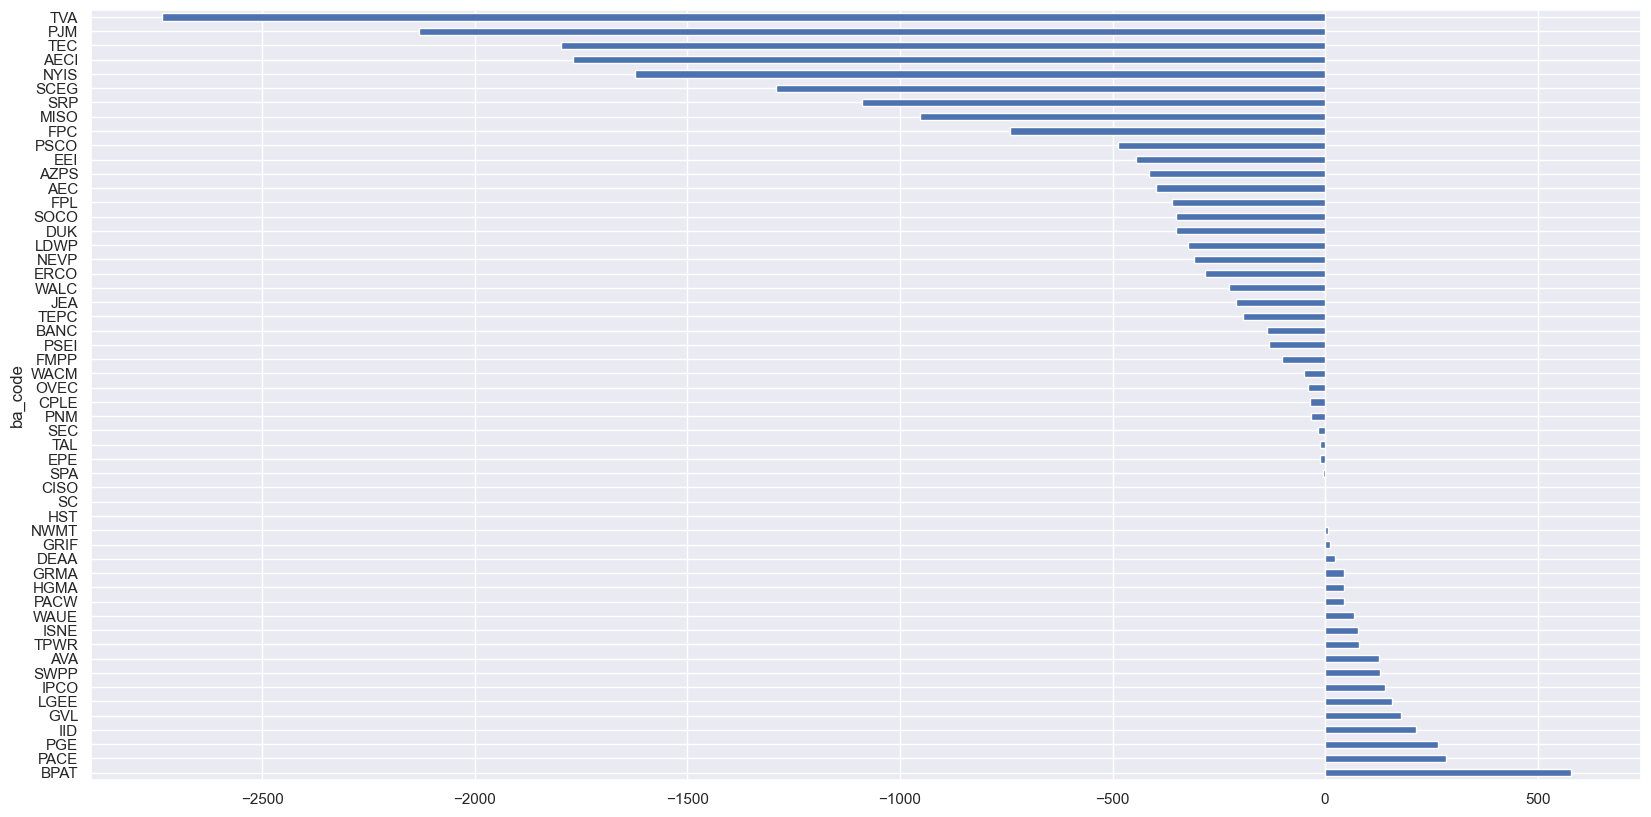

In [221]:
co2_annual['delta_co2_kton_pred'].sort_values(ascending=False).plot(kind='barh', figsize = (20,10))
